# Network Security Analysis Agent - Complete Workflow

This notebook provides a complete step-by-step workflow for network security analysis using Amazon Bedrock and Claude.

## Overview
1. **Setup & Dependencies** - Install required packages
2. **Data Loading** - Load network logs from CSV
3. **Data Extraction & Transformation** - Process network logs
4. **Agent Creation** - Initialize Bedrock agent with tools
5. **Security Analysis** - Run threat detection
6. **Results & Visualization** - Display findings

## 1. Setup & Dependencies

In [ ]:
# Install required packages
!pip install boto3 langchain-aws langchain-community pandas numpy matplotlib seaborn certifi

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import json
import random
import ssl
import certifi
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from langchain_aws import ChatBedrock
from langchain.tools import Tool
from langchain.agents import initialize_agent, AgentType
import boto3
import warnings
warnings.filterwarnings('ignore')

# Fix SSL certificate issues on macOS
import os
os.environ['SSL_CERT_FILE'] = certifi.where()
os.environ['REQUESTS_CA_BUNDLE'] = certifi.where()

print("✅ All libraries imported successfully")

✅ All libraries imported successfully


## 2. Data Loading

In [3]:
# Load network logs from CSV file
df = pd.read_csv('network_logs.csv')
print(f"✅ Loaded {len(df)} network log records")
print(f"📊 Data shape: {df.shape}")
df.head()

✅ Loaded 1130 network log records
📊 Data shape: (1130, 58)


,tenantId,deviceId,Timestamp,traceId,metadata,DeviceType,EventType,AC_RuleAction,ClientAppDetector,ConnectionID,...,SignatureRevision,IntrusionRuleMessage,Classification,IntrusionPolicy,InlineResult,InlineResultReason,AC_RuleReason,IP_ReputationSI_Category,SI_Direction,IntrusionCount
0,f8948c2f-3138-497b-a56e-17e0fd442e5e,3cb5b0f3-f53c-4b2b-892f-3456b193ffa6,1744652926,1178450c-84a4-4cdf-8eab-92d11680f817,NaN,FTD,ConnectionEvent,Allow,AppID,15606,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,f8948c2f-3138-497b-a56e-17e0fd442e5e,3cb5b0f3-f53c-4b2b-892f-3456b193ffa6,1744652926,f2e24c41-ea8c-4c03-8916-f918722225a9,NaN,FTD,ConnectionEvent,Allow,AppID,15501,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,f8948c2f-3138-497b-a56e-17e0fd442e5e,3cb5b0f3-f53c-4b2b-892f-3456b193ffa6,1744652931,8aa2780b-4e6b-4fc0-b9b1-502f1ead4895,NaN,FTD,IntrusionEvent,NaN,NaN,15609,...,2.0,(udp) large UDP packet (> 4000 bytes),Potentially Bad Traffic,manisb-maximum-detection-only,Would block,"Intrusion Policy in ""Detection"" Inspection Mode",NaN,NaN,NaN,NaN
3,f8948c2f-3138-497b-a56e-17e0fd442e5e,3cb5b0f3-f53c-4b2b-892f-3456b193ffa6,1744652931,cc436106-0c2f-4409-a456-eed2bc62b584,NaN,FTD,ConnectionEvent,Allow,AppID,15609,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,f8948c2f-3138-497b-a56e-17e0fd442e5e,3cb5b0f3-f53c-4b2b-892f-3456b193ffa6,1744652936,0cd854f2-0f6a-4267-8b89-f14e1b964e99,NaN,FTD,ConnectionEvent,Allow,AppID,15587,...,NaN,NaN,Generic Protocol Command Decode,NaN,NaN,NaN,IP Monitor,block-list-for-SI-events-ip,Destination,NaN


## 3. Data Extraction & Transformation

In [4]:
print(f"📈 Dataset Overview:")
print(f"Total records: {len(df):,}")
print(f"Date range: {df['Timestamp'].min()} to {df['Timestamp'].max()}")
print(f"Unique source IPs: {df['InitiatorIP'].nunique()}")
print(f"Unique destination IPs: {df['ResponderIP'].nunique()}")
# Calculate total bytes if not exists
if 'TotalBytes' not in df.columns:
    df['TotalBytes'] = df['InitiatorBytes'].fillna(0) + df['ResponderBytes'].fillna(0)

print(f"Total data transferred: {df['TotalBytes'].sum() / 1024 / 1024:.2f} MB")

📈 Dataset Overview:
Total records: 1,130
Date range: 1744650006 to 1744653721
Unique source IPs: 8
Unique destination IPs: 6
Total data transferred: 654.48 MB


In [5]:
def extract_network_statistics(df):
    """Extract comprehensive network statistics for LLM analysis"""
    
    # Define suspicious and common ports
    suspicious_ports = [31337, 1337, 4444, 6666, 12345, 54321]
    common_ports = [80, 443, 22, 21, 25, 53, 110, 143, 993, 995, 3389, 5432, 3306]
    
    # Calculate total bytes (InitiatorBytes + ResponderBytes)
    if 'TotalBytes' not in df.columns:
        df['TotalBytes'] = df['InitiatorBytes'].fillna(0) + df['ResponderBytes'].fillna(0)
    
    # Basic overview
    total_connections = len(df)
    unique_source_ips = df['InitiatorIP'].nunique()
    unique_dest_ips = df['ResponderIP'].nunique()
    total_bytes = df['TotalBytes'].sum()
    
    # Data transfer analysis
    bytes_95th = df['TotalBytes'].quantile(0.95)
    large_transfers = df[df['TotalBytes'] > bytes_95th]
    
    # Port analysis
    suspicious_connections = df[df['ResponderPort'].isin(suspicious_ports)]
    uncommon_ports = df[~df['ResponderPort'].isin(common_ports + suspicious_ports)]
    
    # Source IP analysis
    ip_stats = df.groupby('InitiatorIP').agg({
        'ResponderPort': 'nunique',
        'TotalBytes': ['sum', 'count'],
        'ResponderIP': 'nunique'
    }).round(2)
    
    ip_stats.columns = ['unique_ports', 'total_bytes', 'connection_count', 'unique_destinations']
    potential_scanners = ip_stats[ip_stats['unique_ports'] > 10]
    high_volume_sources = ip_stats.nlargest(5, 'total_bytes')
    
    # Protocol distribution
    protocol_dist = df['Protocol'].value_counts().to_dict()
    
    # Time-based analysis
    df['Hour'] = pd.to_datetime(df['Timestamp']).dt.hour
    hourly_activity = df.groupby('Hour').size().to_dict()
    
    # Compile statistics
    stats = {
        "overview": {
            "total_connections": total_connections,
            "unique_source_ips": unique_source_ips,
            "unique_destination_ips": unique_dest_ips,
            "total_bytes_mb": round(total_bytes / 1024 / 1024, 2),
            "avg_bytes_per_connection": round(total_bytes / total_connections, 2)
        },
        "data_transfer_analysis": {
            "large_transfers_count": len(large_transfers),
            "large_transfers_threshold_mb": round(bytes_95th / 1024 / 1024, 2),
            "max_single_transfer_mb": round(df['TotalBytes'].max() / 1024 / 1024, 2),
            "top_data_transfers": large_transfers.nlargest(10, 'TotalBytes')[['InitiatorIP', 'ResponderIP', 'TotalBytes', 'ResponderPort']].to_dict('records')
        },
        "port_analysis": {
            "suspicious_port_connections": len(suspicious_connections),
            "uncommon_port_connections": len(uncommon_ports),
            "most_targeted_ports": df['ResponderPort'].value_counts().head(10).to_dict()
        },
        "source_ip_analysis": {
            "potential_port_scanners": len(potential_scanners),
            "scanner_details": potential_scanners.to_dict('index') if len(potential_scanners) > 0 else {},
            "high_volume_sources": high_volume_sources.to_dict('index')
        },
        "protocol_distribution": protocol_dist,
        "temporal_analysis": {
            "hourly_activity_distribution": hourly_activity,
            "peak_activity_hour": max(hourly_activity, key=hourly_activity.get)
        }
    }
    
    return stats

# Extract statistics
network_stats = extract_network_statistics(df)
print("✅ Network statistics extracted successfully")
print(f"📊 Found {network_stats['data_transfer_analysis']['large_transfers_count']} large transfers")
print(f"🔍 Found {network_stats['source_ip_analysis']['potential_port_scanners']} potential scanners")

✅ Network statistics extracted successfully
📊 Found 56 large transfers
🔍 Found 0 potential scanners


## 4. Data Visualization

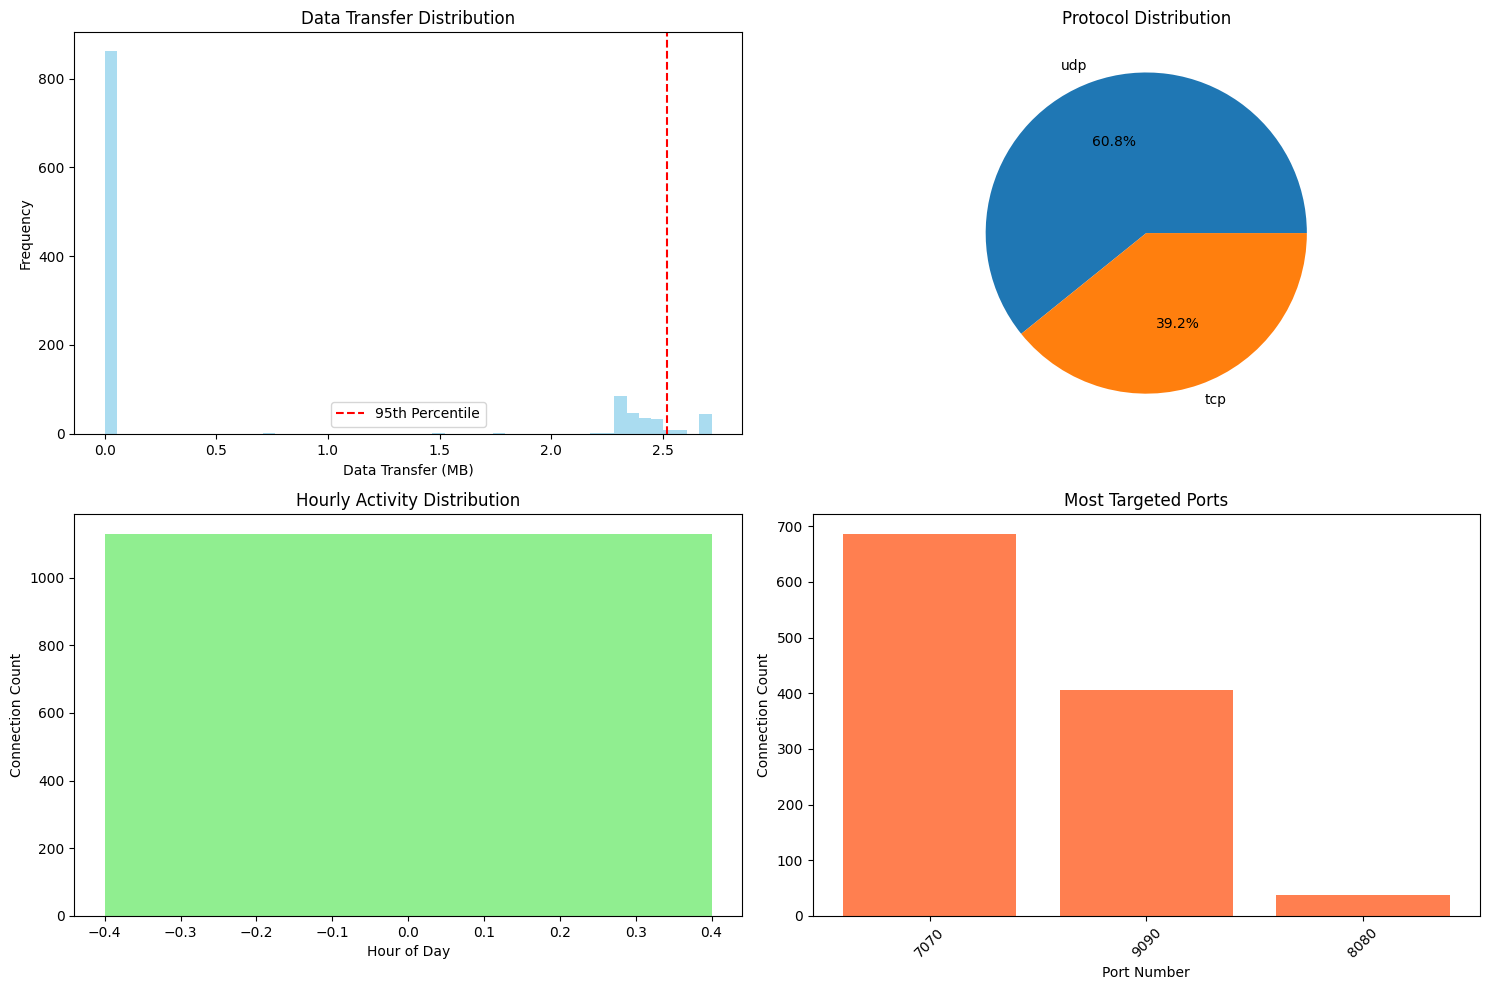

📈 Visualizations generated successfully


In [6]:
# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Ensure TotalBytes exists for visualization
if 'TotalBytes' not in df.columns:
    df['TotalBytes'] = df['InitiatorBytes'].fillna(0) + df['ResponderBytes'].fillna(0)

# Data transfer distribution
axes[0,0].hist(df['TotalBytes'] / 1024 / 1024, bins=50, alpha=0.7, color='skyblue')
axes[0,0].axvline(network_stats['data_transfer_analysis']['large_transfers_threshold_mb'], 
                  color='red', linestyle='--', label='95th Percentile')
axes[0,0].set_xlabel('Data Transfer (MB)')
axes[0,0].set_ylabel('Frequency')
axes[0,0].set_title('Data Transfer Distribution')
axes[0,0].legend()

# Protocol distribution
protocol_data = list(network_stats['protocol_distribution'].values())
protocol_labels = list(network_stats['protocol_distribution'].keys())
axes[0,1].pie(protocol_data, labels=protocol_labels, autopct='%1.1f%%')
axes[0,1].set_title('Protocol Distribution')

# Hourly activity
hours = list(network_stats['temporal_analysis']['hourly_activity_distribution'].keys())
activity = list(network_stats['temporal_analysis']['hourly_activity_distribution'].values())
axes[1,0].bar(hours, activity, color='lightgreen')
axes[1,0].set_xlabel('Hour of Day')
axes[1,0].set_ylabel('Connection Count')
axes[1,0].set_title('Hourly Activity Distribution')

# Top ports
top_ports = dict(list(network_stats['port_analysis']['most_targeted_ports'].items())[:10])
axes[1,1].bar(range(len(top_ports)), list(top_ports.values()), color='coral')
axes[1,1].set_xticks(range(len(top_ports)))
axes[1,1].set_xticklabels(list(top_ports.keys()), rotation=45)
axes[1,1].set_xlabel('Port Number')
axes[1,1].set_ylabel('Connection Count')
axes[1,1].set_title('Most Targeted Ports')

plt.tight_layout()
plt.show()

print("📈 Visualizations generated successfully")

## 5. Agent Creation & Configuration with Tools

In [7]:
class NetworkSecurityAgent:
    def __init__(self, use_bedrock=True):
        self.use_bedrock = use_bedrock
        self.suspicious_ports = [31337, 1337, 4444, 6666, 12345, 54321]
        self.common_ports = [80, 443, 22, 21, 25, 53, 110, 143, 993, 995, 3389, 5432, 3306]
        
        if use_bedrock:
            try:
                region_name='us-east-1'
                self.bedrock_client = boto3.client('bedrock-runtime', 
                                                   region_name=region_name,
                                                   verify=certifi.where()
                                                   )
                self.llm = ChatBedrock(
                    model_id="anthropic.claude-3-sonnet-20240229-v1:0",
                    client=self.bedrock_client,
                    model_kwargs={
                        "max_tokens": 2000,
                        "temperature": 0.1,
                        "top_p": 0.9
                    }
                )
        
                # Initialize tools
                self.tools = self._create_tools()
                
                # Create agent with tools
                self.agent = initialize_agent(
                    tools=self.tools,
                    llm=self.llm,
                    agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
                    verbose=True
                )
                
                print("✅ Bedrock agent with tools initialized successfully")
            except Exception as e:
                print(f"❌ Bedrock initialization failed: {e}")
                print("🔄 Falling back to demo mode")
                self.use_bedrock = False
    
    def _create_tools(self):
        """Create analysis tools for the agent"""
        
        def analyze_large_transfers(data_str: str) -> str:
            """Analyze large data transfers from network statistics"""
            try:
                data = json.loads(data_str)
                transfers = data.get('data_transfer_analysis', {})
                large_count = transfers.get('large_transfers_count', 0)
                threshold = transfers.get('large_transfers_threshold_mb', 0)
                max_transfer = transfers.get('max_single_transfer_mb', 0)
                
                if large_count > 50:
                    risk = "HIGH"
                elif large_count > 20:
                    risk = "MEDIUM"
                else:
                    risk = "LOW"
                
                return f"Large Transfer Analysis: {large_count} transfers above {threshold}MB threshold. Max transfer: {max_transfer}MB. Risk Level: {risk}"
            except:
                return "Error analyzing large transfers"
        
        def detect_port_scanning(data_str: str) -> str:
            """Detect potential port scanning behavior"""
            try:
                data = json.loads(data_str)
                scanners = data.get('source_ip_analysis', {}).get('potential_port_scanners', 0)
                scanner_details = data.get('source_ip_analysis', {}).get('scanner_details', {})
                
                if scanners > 0:
                    details = []
                    for ip, stats in list(scanner_details.items())[:3]:
                        details.append(f"{ip}: {stats['unique_ports']} ports, {stats['connection_count']} connections")
                    return f"Port Scanning Detected: {scanners} potential scanners. Top scanners: {'; '.join(details)}"
                else:
                    return "No port scanning behavior detected"
            except:
                return "Error analyzing port scanning"
        
        def analyze_suspicious_ports(data_str: str) -> str:
            """Analyze connections to suspicious ports"""
            try:
                data = json.loads(data_str)
                suspicious_count = data.get('port_analysis', {}).get('suspicious_port_connections', 0)
                uncommon_count = data.get('port_analysis', {}).get('uncommon_port_connections', 0)
                
                if suspicious_count > 0:
                    return f"ALERT: {suspicious_count} connections to known suspicious ports detected!"
                elif uncommon_count > 100:
                    return f"WARNING: {uncommon_count} connections to uncommon ports - investigate further"
                else:
                    return f"Port analysis: {uncommon_count} uncommon port connections (normal range)"
            except:
                return "Error analyzing suspicious ports"
        
        def calculate_risk_score(data_str: str) -> str:
            """Calculate overall network risk score"""
            try:
                data = json.loads(data_str)
                score = 0
                factors = []
                
                # Large transfers
                large_transfers = data.get('data_transfer_analysis', {}).get('large_transfers_count', 0)
                if large_transfers > 50:
                    score += 3
                    factors.append(f"High volume transfers ({large_transfers})")
                elif large_transfers > 20:
                    score += 2
                    factors.append(f"Moderate volume transfers ({large_transfers})")
                
                # Port scanning
                scanners = data.get('source_ip_analysis', {}).get('potential_port_scanners', 0)
                if scanners > 0:
                    score += 4
                    factors.append(f"Port scanning detected ({scanners} sources)")
                
                # Suspicious ports
                suspicious_ports = data.get('port_analysis', {}).get('suspicious_port_connections', 0)
                if suspicious_ports > 0:
                    score += 5
                    factors.append(f"Suspicious port usage ({suspicious_ports} connections)")
                
                # Source diversity
                unique_sources = data.get('overview', {}).get('unique_source_ips', 0)
                if unique_sources < 5:
                    score += 2
                    factors.append("Low source diversity")
                
                risk_level = "LOW" if score < 3 else "MEDIUM" if score < 6 else "HIGH" if score < 8 else "CRITICAL"
                
                return f"Risk Score: {min(score, 10)}/10 ({risk_level}). Factors: {'; '.join(factors) if factors else 'No significant risk factors'}"
            except:
                return "Error calculating risk score"
        
        return [
            Tool(
                name="analyze_large_transfers",
                description="Analyze large data transfers in network traffic",
                func=analyze_large_transfers
            ),
            Tool(
                name="detect_port_scanning",
                description="Detect potential port scanning behavior",
                func=detect_port_scanning
            ),
            Tool(
                name="analyze_suspicious_ports",
                description="Analyze connections to suspicious or uncommon ports",
                func=analyze_suspicious_ports
            ),
            Tool(
                name="calculate_risk_score",
                description="Calculate overall network security risk score",
                func=calculate_risk_score
            )
        ]
    
    def analyze_network_security(self, network_stats):
        """Analyze network statistics for security threats"""
        
        if self.use_bedrock:
            return self._bedrock_analysis_with_tools(network_stats)
        else:
            return self._demo_analysis(network_stats)
    
    def _bedrock_analysis_with_tools(self, network_stats):
        """Enhanced Bedrock analysis using tools"""
        data_str = json.dumps(network_stats)
        
        prompt = f"""
        You are a cybersecurity expert analyzing network traffic data. Use the available tools to analyze the network statistics and provide a comprehensive security assessment.
        
        Network Statistics: {data_str}
        
        Please use the tools to:
        1. Analyze large data transfers
        2. Detect port scanning behavior  
        3. Check for suspicious port usage
        4. Calculate an overall risk score
        
        Then provide a comprehensive report with:
        - Executive Summary
        - Detailed Threat Assessment
        - Risk Score and Justification
        - Specific Recommendations
        """
        
        try:
            response = self.agent.run(prompt)
            return response
        except Exception as e:
            print(f"Tool-based analysis failed: {e}")
            return self._bedrock_analysis(network_stats)
    
    def _bedrock_analysis(self, network_stats):
        """Fallback Bedrock analysis without tools"""
        prompt = f"""
You are a cybersecurity expert analyzing network traffic data. Based on the following network statistics, provide a comprehensive security assessment.

Network Statistics:
{json.dumps(network_stats, indent=2)}

Please provide:
1. EXECUTIVE SUMMARY (2-3 sentences)
2. THREAT ASSESSMENT with specific findings categorized as:
   - Critical Threats
   - High Priority Issues
   - Medium Priority Issues
   - Low Priority Issues
3. RISK SCORE (1-10 scale)
4. RECOMMENDED ACTIONS (specific next steps)

Focus on:
- Data exfiltration patterns
- Port scanning behavior
- Unusual data transfer volumes
- Suspicious source-destination pairs
- Temporal anomalies
"""
        
        try:
            response = self.llm.invoke(prompt)
            return response.content
        except Exception as e:
            return f"Error during Bedrock analysis: {e}"
    
    def _demo_analysis(self, network_stats):
        """Demo analysis without Bedrock"""
        overview = network_stats['overview']
        transfers = network_stats['data_transfer_analysis']
        sources = network_stats['source_ip_analysis']
        
        risk_score = 3
        threats = []
        
        if transfers['large_transfers_count'] > 20:
            risk_score += 2
            threats.append(f"High volume data transfers: {transfers['large_transfers_count']} transfers exceed threshold")
        
        if sources['potential_port_scanners'] > 0:
            risk_score += 3
            threats.append(f"Port scanning detected: {sources['potential_port_scanners']} potential scanners")
        
        if overview['unique_source_ips'] < 10:
            risk_score += 1
            threats.append("Limited source diversity may indicate concentrated attack")
        
        return f"""
## EXECUTIVE SUMMARY
Analysis of {overview['total_connections']:,} network connections from {overview['unique_source_ips']} unique sources.
Total data transfer: {overview['total_bytes_mb']:.2f} MB with {transfers['large_transfers_count']} large transfers detected.

## THREAT ASSESSMENT
### Identified Issues:
{chr(10).join(f'- {threat}' for threat in threats) if threats else '- No significant threats detected'}

### Key Metrics:
- Largest single transfer: {transfers['max_single_transfer_mb']:.2f} MB
- Large transfer threshold: {transfers['large_transfers_threshold_mb']:.2f} MB
- Potential scanners: {sources['potential_port_scanners']}

## RISK SCORE: {min(risk_score, 10)}/10

## RECOMMENDED ACTIONS
1. Investigate large data transfers above {transfers['large_transfers_threshold_mb']:.2f} MB
2. Monitor source IPs with high connection counts
3. Review connections to uncommon ports
4. Implement additional monitoring for detected patterns
"""

# Initialize agent
agent = NetworkSecurityAgent(use_bedrock=True)  # Set to False for demo mode

✅ Bedrock agent with tools initialized successfully


## 6. Security Analysis Execution

In [8]:
# Run security analysis
print("🔍 Running network security analysis...")
print("⏳ This may take a few moments...\n")

analysis_result = agent.analyze_network_security(network_stats)

print("="*80)
print("🛡️  NETWORK SECURITY ANALYSIS REPORT")
print("="*80)
print(analysis_result)
print("="*80)

🔍 Running network security analysis...
⏳ This may take a few moments...



> Entering new AgentExecutor chain...
To provide a comprehensive security assessment, I will need to utilize all the available tools and analyze the different aspects of the network traffic data. Here's my plan:

Thought: First, I should analyze the large data transfers to identify any potential data exfiltration or malicious file transfers.
Action: analyze_large_transfers
Action Input: {"overview": {"total_connections": 1130, "unique_source_ips": 8, "unique_destination_ips": 6, "total_bytes_mb": 654.48, "avg_bytes_per_connection": 607319.65}, "data_transfer_analysis": {"large_transfers_count": 56, "large_transfers_threshold_mb": 2.52, "max_single_transfer_mb": 2.72, "top_data_transfers": [{"InitiatorIP": "000000000000000000000000ac10001d", "ResponderIP": "000000000000000000000000ac104008", "TotalBytes": 2850960.0, "ResponderPort": 7070}, {"InitiatorIP": "000000000000000000000000ac10001d", "ResponderIP": "000000

## 7. Detailed Statistics Summary

In [9]:
# Display detailed statistics
print("📊 DETAILED NETWORK STATISTICS")
print("="*50)

print(f"\n🌐 OVERVIEW:")
for key, value in network_stats['overview'].items():
    print(f"  {key.replace('_', ' ').title()}: {value:,}")

print(f"\n📈 DATA TRANSFERS:")
for key, value in network_stats['data_transfer_analysis'].items():
    if key != 'top_data_transfers':
        print(f"  {key.replace('_', ' ').title()}: {value}")

print(f"\n🔌 PORT ANALYSIS:")
for key, value in network_stats['port_analysis'].items():
    if key != 'most_targeted_ports':
        print(f"  {key.replace('_', ' ').title()}: {value}")

print(f"\n🖥️  SOURCE IP ANALYSIS:")
for key, value in network_stats['source_ip_analysis'].items():
    if key not in ['scanner_details', 'high_volume_sources']:
        print(f"  {key.replace('_', ' ').title()}: {value}")

print(f"\n⏰ TEMPORAL ANALYSIS:")
print(f"  Peak Activity Hour: {network_stats['temporal_analysis']['peak_activity_hour']}:00")

# Show top suspicious activities if any
if network_stats['data_transfer_analysis']['large_transfers_count'] > 0:
    print(f"\n🚨 TOP LARGE TRANSFERS:")
    for i, transfer in enumerate(network_stats['data_transfer_analysis']['top_data_transfers'][:5], 1):
        print(f"  {i}. {transfer['InitiatorIP']} → {transfer['ResponderIP']}:{transfer['ResponderPort']} ({transfer['TotalBytes']:,} bytes)")

📊 DETAILED NETWORK STATISTICS

🌐 OVERVIEW:
  Total Connections: 1,130
  Unique Source Ips: 8
  Unique Destination Ips: 6
  Total Bytes Mb: 654.48
  Avg Bytes Per Connection: 607,319.65

📈 DATA TRANSFERS:
  Large Transfers Count: 56
  Large Transfers Threshold Mb: 2.52
  Max Single Transfer Mb: 2.72

🔌 PORT ANALYSIS:
  Suspicious Port Connections: 0
  Uncommon Port Connections: 1130

🖥️  SOURCE IP ANALYSIS:
  Potential Port Scanners: 0

⏰ TEMPORAL ANALYSIS:
  Peak Activity Hour: 0:00

🚨 TOP LARGE TRANSFERS:
  1. 000000000000000000000000ac10001d → 000000000000000000000000ac104008:7070 (2,850,960.0 bytes)
  2. 000000000000000000000000ac10001d → 000000000000000000000000ac104006:7070 (2,850,960.0 bytes)
  3. 000000000000000000000000ac10001d → 000000000000000000000000ac104009:7070 (2,850,960.0 bytes)
  4. 000000000000000000000000ac10001d → 000000000000000000000000ac104008:7070 (2,850,960.0 bytes)
  5. 000000000000000000000000ac10001d → 000000000000000000000000ac104006:7070 (2,850,960.0 bytes

## 8. Export Results

In [10]:
# Save analysis results
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

# Save statistics as JSON
with open(f'network_analysis_stats_{timestamp}.json', 'w') as f:
    json.dump(network_stats, f, indent=2)

# Save analysis report
with open(f'security_analysis_report_{timestamp}.txt', 'w') as f:
    f.write("NETWORK SECURITY ANALYSIS REPORT\n")
    f.write("=" * 50 + "\n\n")
    f.write(str(analysis_result))

print(f"✅ Results exported:")
print(f"  📄 Statistics: network_analysis_stats_{timestamp}.json")
print(f"  📋 Report: security_analysis_report_{timestamp}.txt")
print(f"  📊 Source Data: network_logs.csv")

✅ Results exported:
  📄 Statistics: network_analysis_stats_20250708_204159.json
  📋 Report: security_analysis_report_20250708_204159.txt
  📊 Source Data: network_logs.csv


## 9. Configuration & Next Steps

In [11]:
print("🔧 CONFIGURATION OPTIONS:")
print("\n1. Data Requirements:")
print("   - Uses network_logs.csv in current directory")
print("   - Required columns: Timestamp, InitiatorIP, ResponderIP, ResponderPort, Protocol, InitiatorBytes, ResponderBytes")
print("   - TotalBytes is calculated as InitiatorBytes + ResponderBytes")

print("\n2. To enable full Bedrock integration:")
print("   - Configure AWS credentials: aws configure")
print("   - Enable Bedrock access in AWS console")
print("   - Request Claude model access")

print("\n3. To customize threat detection:")
print("   - Modify suspicious_ports list in extract_network_statistics()")
print("   - Adjust large transfer threshold (currently 95th percentile)")
print("   - Add custom detection rules")

print("\n4. For production use:")
print("   - Implement real-time log streaming")
print("   - Add alerting mechanisms")
print("   - Integrate with SIEM systems")
print("   - Schedule regular analysis")

print("\n✨ Analysis complete! Review the generated report and statistics above.")

🔧 CONFIGURATION OPTIONS:

1. Data Requirements:
   - Uses network_logs.csv in current directory
   - Required columns: Timestamp, InitiatorIP, ResponderIP, ResponderPort, Protocol, InitiatorBytes, ResponderBytes
   - TotalBytes is calculated as InitiatorBytes + ResponderBytes

2. To enable full Bedrock integration:
   - Configure AWS credentials: aws configure
   - Enable Bedrock access in AWS console
   - Request Claude model access

3. To customize threat detection:
   - Modify suspicious_ports list in extract_network_statistics()
   - Adjust large transfer threshold (currently 95th percentile)
   - Add custom detection rules

4. For production use:
   - Implement real-time log streaming
   - Add alerting mechanisms
   - Integrate with SIEM systems
   - Schedule regular analysis

✨ Analysis complete! Review the generated report and statistics above.
